## Web References

### System

- [How to copy a file without using scp inside an ssh session?](https://superuser.com/questions/291423/how-to-copy-a-file-without-using-scp-inside-an-ssh-session)

### PySpark

- [Complete Machine Learning Project with PySpark MLlib Tutorial](https://www.youtube.com/watch?v=1a7bB1ZcZ3k)
- [The ONLY PySpark Tutorial You Will Ever Need.](https://www.youtube.com/watch?v=cZS5xYYIPzk)
- [PySpark When Otherwise | SQL Case When Usage](https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/)
- [Spark rlike() Working with Regex Matching Examples](https://sparkbyexamples.com/spark/spark-rlike-regex-matching-examples/)
- [spark dataframe drop duplicates and keep first](https://stackoverflow.com/questions/38687212/spark-dataframe-drop-duplicates-and-keep-first)
- [Spark SQL Window functions using plain SQL](https://www.linkedin.com/pulse/spark-sql-window-functions-using-plain-ram-ghadiyaram/)
- [Calculate difference with previous row in PySpark](https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html)
- [forward fill with last observation for a DataFrame](https://stackoverflow.com/questions/36019847/pyspark-forward-fill-with-last-observation-for-a-dataframe)
- [Imputer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html)

### Pandas

- [Pandas resample() tricks you should know for manipulating time-series data](https://towardsdatascience.com/pandas-resample-tricks-you-should-know-for-manipulating-time-series-data-7e9643a7e7f3)
- [Resample with categories in pandas, keep non-numerical columns](https://stackoverflow.com/questions/56001927/resample-with-categories-in-pandas-keep-non-numerical-columns)

### Time Series

- [Time Series Analysis with Spark](https://www.youtube.com/watch?v=tKkneWcAIqU)
- [Time Series Stream Processing with Spark and Cassandra](https://www.youtube.com/watch?v=fBWLzB0FMX4)
- [Spark Basics: Missing Data and Time Series](https://www.youtube.com/watch?v=kvLCxHvL7U0)
- [Spark Resampling, Spark UDFs, Resampling Time Series Data with Spark](https://www.youtube.com/watch?v=uFws-jPywmc)

### Anomaly Detection

- [How to Build an Anomaly Detection Engine with Spark, Akka and Cassandra](https://learning.oreilly.com/videos/how-to-build/9781491955253/9781491955253-video244545/)
- [Real Time Detection of Anomalies in the Database Infrastructure using Apache Spark](https://www.youtube.com/watch?v=1IsMMmug5q0)

### Other

- [What is CRISP DM?](https://www.datascience-pm.com/crisp-dm-2/)

### Internet Traffic

- [Data mining approach for predicting the daily Internet data traffic of a smart university](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0176-5)

## Import Libraries

In [34]:
import datetime
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, asc, desc, col, lag, isnull, from_unixtime, year, month, dayofmonth, dayofweek, hour, minute
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

## HDFS Preparation

In [2]:
%%bash
#!/bin/bash

# delete the 
if hadoop fs -test -d router; then
    # delete the output directory
    hadoop fs -rm -r router/output

    # create a new output directory
    hadoop fs -mkdir router/output
else
    # create the router directory and upload the input files
    hadoop fs -mkdir router
    hadoop fs -mkdir router/sample
    hadoop fs -put data/bandwidth.csv router/sample/

    hadoop fs -put data/raw router/raw

    # create the output directory
    hadoop fs -mkdir router/output
fi

hadoop fs -ls router/raw

Found 463 items
-rw-r--r--   3 jfoul001 users     150806 2022-03-08 03:29 router/raw/20220304T2210.csv.gz
-rw-r--r--   3 jfoul001 users     149945 2022-03-08 03:29 router/raw/20220304T2220.csv.gz
-rw-r--r--   3 jfoul001 users     149142 2022-03-08 03:29 router/raw/20220304T2230.csv.gz
-rw-r--r--   3 jfoul001 users     151781 2022-03-08 03:29 router/raw/20220304T2240.csv.gz
-rw-r--r--   3 jfoul001 users     150343 2022-03-08 03:29 router/raw/20220304T2250.csv.gz
-rw-r--r--   3 jfoul001 users     149798 2022-03-08 03:29 router/raw/20220304T2300.csv.gz
-rw-r--r--   3 jfoul001 users     148781 2022-03-08 03:29 router/raw/20220304T2310.csv.gz
-rw-r--r--   3 jfoul001 users     148639 2022-03-08 03:29 router/raw/20220304T2320.csv.gz
-rw-r--r--   3 jfoul001 users     149012 2022-03-08 03:29 router/raw/20220304T2330.csv.gz
-rw-r--r--   3 jfoul001 users     150019 2022-03-08 03:29 router/raw/20220304T2340.csv.gz
-rw-r--r--   3 jfoul001 users     150122 2022-03-08 03:29 router/raw/20220304T2350.c

## Initialize the Spark Session

In [2]:
spark = SparkSession.builder.appName('cw02').getOrCreate()
spark

Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## I. Data Understanding

Identify, collect, and analyze the data sets that will help accomplish the project goals

### A. Collect Initial Data

In [4]:
#input_path = 'router/sample/bandwidth.csv'
input_path = 'router/raw/'

# read the full batch to process
df_batch = spark.read.csv(input_path, header=False, inferSchema=True) \
    .toDF('direction','interval_length','intervals_saved','ip','interval_start','interval_end','bytes_used')

In [5]:
# drop the intervals saved column
df_batch = df_batch.drop('intervals_saved')
print(f'Row Count: {df_batch.count():,}')

Row Count: 9,640,027


Remove records related to a specific upload or download class. This is done because this information is not relevant to the project, and have an additional column that will complicate data processing.

In [6]:
df_batch_preproc = df_batch.where(df_batch['interval_length'].contains('class_') == False)
print(f'Row Count: {df_batch_preproc.count():,}')

Row Count: 7,891,805


### B. Describe data

Examine the data and document its surface properties like data format, number of records, or field identities.

#### 1. Data Format

In [7]:
df_batch_preproc.printSchema()

root
 |-- direction: string (nullable = true)
 |-- interval_length: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)



In [8]:
print(f'Row Count: {df_batch_preproc.count():,}')

Row Count: 7,891,805


#### 2. Remove Duplicates

Many duplicate records are present in the raw data since the data snapshots overlaps.

In [9]:
# drop duplicates
df_unique = df_batch_preproc.drop_duplicates()
print(f'Row Count: {df_unique.count():,}')

Row Count: 1,469,963


There are duplicates where only the `Bytes Used` field is different due to when the data snapshot was taken.

In [10]:
df_unique = df_unique.groupBy(['direction','interval_length','ip','interval_start','interval_end']) \
    .max('bytes_used') \
    .withColumnRenamed('max(bytes_used)', 'bytes_used')

print(f'Row Count: {df_unique.count():,}')

Row Count: 1,409,896


In [11]:
df_unique.show(5)

+---------+---------------+-------------+--------------+------------+----------+
|direction|interval_length|           ip|interval_start|interval_end|bytes_used|
+---------+---------------+-------------+--------------+------------+----------+
|   upload|            day|     COMBINED|    1628805600|  1628892000|4005707937|
| download|         minute|192.168.3.188|    1646632140|  1646632200|        93|
| download|              2| 192.168.1.11|    1646510320|  1646510322|         0|
| download|              2| 192.168.1.11|    1646690298|  1646690300|       104|
| download|              2|     COMBINED|    1646445554|  1646445556|    370850|
+---------+---------------+-------------+--------------+------------+----------+
only showing top 5 rows



### C. Explore data

Dig deeper into the data. Query it, visualize it, and identify relationships among the data.

#### 1. Unique Categories

In [12]:
# if an IP address is stored in the IP column recode it as simply 'IP'
df_interval_type = df_unique.withColumn('interval_type', 
    when(df_unique['ip']
    .rlike('^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'), 'IP')
    .otherwise(df_unique['ip'])
)

df_interval_type.groupBy(['interval_type']).count().show()

+-------------+-------+
|interval_type|  count|
+-------------+-------+
|           IP|1110895|
|     COMBINED| 299001|
+-------------+-------+



In [13]:
# record count per catergory
df_interval_type.groupBy(['interval_length', 'interval_type']) \
    .count() \
    .orderBy(['interval_length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|interval_length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  5410|
|              2|     COMBINED|279429|
|              2|           IP|870584|
|           7200|     COMBINED|   872|
|            900|     COMBINED|  1286|
|            900|           IP| 30491|
|            day|     COMBINED|   744|
|            day|           IP|  4052|
|           hour|     COMBINED|   334|
|           hour|           IP|  9498|
|         minute|     COMBINED| 10904|
|         minute|           IP|193385|
|          month|     COMBINED|    22|
|          month|           IP|  2885|
+---------------+-------------+------+



#### 2. How many intervals are available for the various categories?

This number should be less as for every interval there could be multiple IP addresses (where `interval_type == 'IP'`).

In [14]:
df_interval_type.drop_duplicates(['direction', 'interval_length', 'interval_type', 'interval_start', 'interval_end']) \
    .groupBy(['interval_length', 'interval_type']) \
    .count() \
    .orderBy(['interval_length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|interval_length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  5410|
|              2|     COMBINED|279429|
|              2|           IP|279633|
|           7200|     COMBINED|   872|
|            900|     COMBINED|  1286|
|            900|           IP|  1286|
|            day|     COMBINED|   744|
|            day|           IP|    76|
|           hour|     COMBINED|   334|
|           hour|           IP|   334|
|         minute|     COMBINED| 10904|
|         minute|           IP| 10206|
|          month|     COMBINED|    22|
|          month|           IP|    28|
+---------------+-------------+------+



#### 3. Minute Plot

Group the minute data by interval and show a line plot of the first twho hours for a visual overview of the data.

In [15]:
# get the summarized data
df_interval_bandwidth = df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP')) \
    .groupBy(['interval_start']) \
    .sum('bytes_used') \
    .orderBy(['interval_start'], ascending=True) \
    .withColumnRenamed('sum(bytes_used)', 'bytes_used') \
    .limit(2 * 60) \
    .toPandas()

df_interval_bandwidth.describe()

,bytes_used
count,1.200000e+02
mean,2.216871e+07
std,3.043667e+07
min,4.337154e+06
25%,7.530486e+06
50%,9.770354e+06
75%,1.722035e+07
max,1.445253e+08


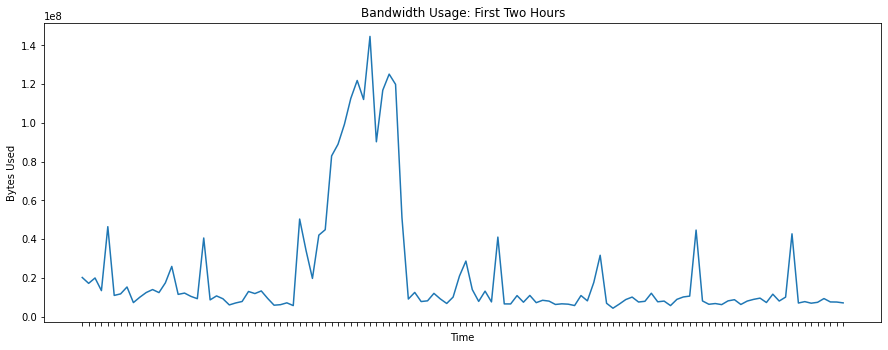

In [16]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_bandwidth,
    x='interval_start',
    y='bytes_used',
    ax=ax
).set(
    title='Bandwidth Usage: First Two Hours',
    ylabel='Bytes Used',
    xlabel='Time',
    xticklabels=[])

plt.show()

#### 4. Number of IP addresses in the last two hours

Notes:

- To count the number of local IP addresses use the `startswith` filter of `192.`
- The dataset contains incomplete intervals where `Interval End == 0` to indicate that the interval was not yet complete when the snapshot was taken.

In [17]:
# the filter on IP is to select only local IP addresses
df_interval_clients = spark.createDataFrame(df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           (df_interval_type['ip'].startswith('192.')) &
           (df_interval_type['interval_end'] > 0)) \
    .drop_duplicates(['ip', 'interval_start', 'interval_end']) \
    .groupBy(['interval_start']) \
    .count() \
    .orderBy(['interval_start'], ascending=True) \
    .tail(2 * 60)) \
    .toPandas()

df_interval_clients.describe()

,count
count,120.000000
mean,17.933333
std,1.034963
min,17.000000
25%,17.000000
50%,18.000000
75%,19.000000
max,20.000000


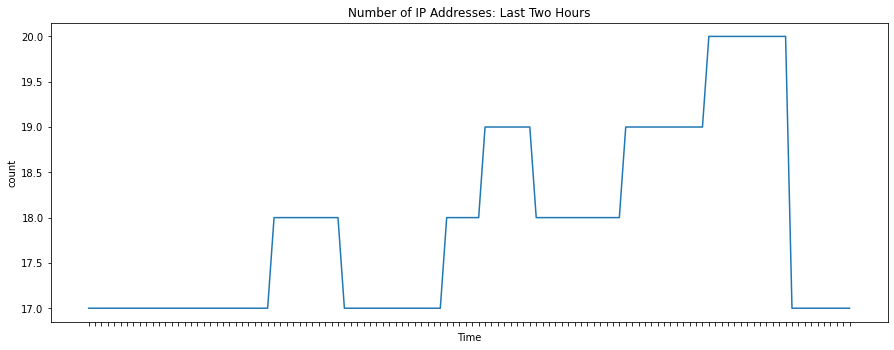

In [18]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_clients,
    x='interval_start',
    y='count',
    ax=ax
).set(
    title='Number of IP Addresses: Last Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()

### D. Verify data quality

#### 1. Select only data by minute with an IP address

In [19]:
df_minute = df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           ((df_interval_type['interval_end'] > 0))) 

print(f'Row Count: {df_minute.count():,}')

Row Count: 175,635


In [20]:
# verify that no null values are present in the dataset
assert df_minute.count() == df_minute.dropna().count()

In [21]:
# save the dataset to HDFS
df_minute.write.parquet('router/output/minute', mode='overwrite', compression='gzip')

#### 2. Find data gaps

In [22]:
# get the unique intervals
df_unique_intervals = df_minute \
    .drop_duplicates(['interval_start', 'interval_end']) \
    .drop('direction') \
    .drop('interval_length') \
    .drop('interval_end') \
    .drop('ip') \
    .drop('bytes_used') \
    .drop('interval_type')

interval_window = Window.partitionBy().orderBy('interval_start')

# add the previous interval start value
df_prev = df_unique_intervals \
    .withColumn('prev_interval_start', lag('interval_start', 1).over(interval_window))

# calculate the difference
df_prev = df_prev \
    .withColumn('diff', when(isnull(df_prev.prev_interval_start), 0) \
                       .otherwise(df_prev['interval_start'] - df_prev['prev_interval_start']))


df_prev.show(10)


+--------------+-------------------+----+
|interval_start|prev_interval_start|diff|
+--------------+-------------------+----+
|    1646430900|               null| 0.0|
|    1646430960|         1646430900|60.0|
|    1646431020|         1646430960|60.0|
|    1646431080|         1646431020|60.0|
|    1646431140|         1646431080|60.0|
|    1646431200|         1646431140|60.0|
|    1646431260|         1646431200|60.0|
|    1646431320|         1646431260|60.0|
|    1646431380|         1646431320|60.0|
|    1646431440|         1646431380|60.0|
+--------------+-------------------+----+
only showing top 10 rows



In [23]:
df_prev.select('diff').summary().show()

+-------+-----------------+
|summary|             diff|
+-------+-----------------+
|  count|             4640|
|   mean|60.05172413793103|
| stddev|4.491557221062525|
|    min|              0.0|
|    25%|             60.0|
|    50%|             60.0|
|    75%|             60.0|
|    max|            360.0|
+-------+-----------------+



In [24]:
df_prev.where('diff > 60').show()

+--------------+-------------------+-----+
|interval_start|prev_interval_start| diff|
+--------------+-------------------+-----+
|    1646574900|         1646574540|360.0|
+--------------+-------------------+-----+



## II. Data Preparation

### A. Select Data

In [4]:
# load the dataset form the previous section
df_source = spark.read.parquet('router/output/minute')
print(f'Row Count: {df_source.count():,}')

Row Count: 175,635


In [5]:
df_source.printSchema()

root
 |-- direction: string (nullable = true)
 |-- interval_length: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)
 |-- interval_type: string (nullable = true)



### B. Clean Data

#### 1. Remove the `interval_type` and `interval_length` columns

In [6]:
df_minute = df_source \
    .drop('interval_type') \
    .drop('interval_length')

df_minute.show(5)

+---------+--------------+--------------+------------+----------+
|direction|            ip|interval_start|interval_end|bytes_used|
+---------+--------------+--------------+------------+----------+
|   upload| 192.168.3.125|    1646530380|  1646530440|      4531|
| download| 192.168.3.246|    1646522820|  1646522880|      4755|
| download|197.94.242.117|    1646551320|  1646551380|      8065|
|   upload| 192.168.3.168|    1646604420|  1646604480|         0|
|   upload| 192.168.1.189|    1646630580|  1646630640|    138278|
+---------+--------------+--------------+------------+----------+
only showing top 5 rows



#### 2. Add a `time` columns from the interval start end end epoch

In [7]:
# convert epoch columns to datetime
df_minute = df_minute \
    .withColumn('interval_start_time', from_unixtime(df_minute['interval_start'])) \
    .withColumn('interval_end_time', from_unixtime(df_minute['interval_end']))

df_minute.show(5)

+---------+--------------+--------------+------------+----------+-------------------+-------------------+
|direction|            ip|interval_start|interval_end|bytes_used|interval_start_time|  interval_end_time|
+---------+--------------+--------------+------------+----------+-------------------+-------------------+
|   upload| 192.168.3.125|    1646530380|  1646530440|      4531|2022-03-06 01:33:00|2022-03-06 01:34:00|
| download| 192.168.3.246|    1646522820|  1646522880|      4755|2022-03-05 23:27:00|2022-03-05 23:28:00|
| download|197.94.242.117|    1646551320|  1646551380|      8065|2022-03-06 07:22:00|2022-03-06 07:23:00|
|   upload| 192.168.3.168|    1646604420|  1646604480|         0|2022-03-06 22:07:00|2022-03-06 22:08:00|
|   upload| 192.168.1.189|    1646630580|  1646630640|    138278|2022-03-07 05:23:00|2022-03-07 05:24:00|
+---------+--------------+--------------+------------+----------+-------------------+-------------------+
only showing top 5 rows



### C. Construct Data

#### 1. Add Date Features

In [8]:
df_minute_date = df_minute \
    .withColumn('year', year(df_minute['interval_start_time'])) \
    .withColumn('month', month(df_minute['interval_start_time'])) \
    .withColumn('day', dayofmonth(df_minute['interval_start_time'])) \
    .withColumn('day_of_week', dayofweek(df_minute['interval_start_time'])) \
    .withColumn('hour', hour(df_minute['interval_start_time'])) \
    .withColumn('minute', minute(df_minute['interval_start_time']))

df_minute_date.show(5)

+---------+--------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+
|direction|            ip|interval_start|interval_end|bytes_used|interval_start_time|  interval_end_time|year|month|day|day_of_week|hour|minute|
+---------+--------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+
|   upload| 192.168.3.125|    1646530380|  1646530440|      4531|2022-03-06 01:33:00|2022-03-06 01:34:00|2022|    3|  6|          1|   1|    33|
| download| 192.168.3.246|    1646522820|  1646522880|      4755|2022-03-05 23:27:00|2022-03-05 23:28:00|2022|    3|  5|          7|  23|    27|
| download|197.94.242.117|    1646551320|  1646551380|      8065|2022-03-06 07:22:00|2022-03-06 07:23:00|2022|    3|  6|          1|   7|    22|
|   upload| 192.168.3.168|    1646604420|  1646604480|         0|2022-03-06 22:07:00|2022-03-06 22:08:00|2022|    3|  6|          

#### 2. VLAN Feature

In [9]:
df_minute_vlan_all = df_minute_date \
    .withColumn('vlan', when(df_minute_date['ip'].startswith('192.168.1'), 'private') \
                        .when(df_minute_date['ip'].startswith('192.168.3'), 'tenants') \
                        .when(df_minute_date['ip'].startswith('192.168'), 'other') \
                        .otherwise('internal'))

df_minute_vlan_all.show(5)

+---------+--------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+--------+
|direction|            ip|interval_start|interval_end|bytes_used|interval_start_time|  interval_end_time|year|month|day|day_of_week|hour|minute|    vlan|
+---------+--------------+--------------+------------+----------+-------------------+-------------------+----+-----+---+-----------+----+------+--------+
|   upload| 192.168.3.125|    1646530380|  1646530440|      4531|2022-03-06 01:33:00|2022-03-06 01:34:00|2022|    3|  6|          1|   1|    33| tenants|
| download| 192.168.3.246|    1646522820|  1646522880|      4755|2022-03-05 23:27:00|2022-03-05 23:28:00|2022|    3|  5|          7|  23|    27| tenants|
| download|197.94.242.117|    1646551320|  1646551380|      8065|2022-03-06 07:22:00|2022-03-06 07:23:00|2022|    3|  6|          1|   7|    22|internal|
|   upload| 192.168.3.168|    1646604420|  1646604480|         0|2022-03-06 

In [10]:
# summary of networks in the dataset
df_distinct_ip = df_minute_vlan_all \
    .select('ip', 'vlan') \
    .distinct()

df_distinct_ip.groupBy('vlan').count().show()

+--------+-----+
|    vlan|count|
+--------+-----+
| tenants|   22|
|internal|    2|
| private|   11|
+--------+-----+



- `197.95.152.171` is the public IP of the switch.
- `172.17.0.2` is the internal IP address of the router.

In [11]:
df_distinct_ip.where('vlan == "internal"').show()

+--------------+--------+
|            ip|    vlan|
+--------------+--------+
|197.94.242.117|internal|
|    172.17.0.2|internal|
+--------------+--------+



In [15]:
# how much data are used by the vlan categories
df_summary_vlan = df_minute_vlan_all \
    .groupBy('direction', 'vlan') \
    .sum('bytes_used') \
    .orderBy('direction', 'vlan') \


df_summary_vlan.show()


+---------+--------+---------------+
|direction|    vlan|sum(bytes_used)|
+---------+--------+---------------+
| download|internal|       62904480|
| download| private|    34292396932|
| download| tenants|    89376782567|
|   upload|internal|       26040745|
|   upload| private|     2135821851|
|   upload| tenants|    13589236825|
+---------+--------+---------------+



[Text(0.5, 1.0, 'Bandwidth Usage by VLAN'),
 Text(0, 0.5, 'Bytes Used'),
 Text(0.5, 0, 'VLAN')]

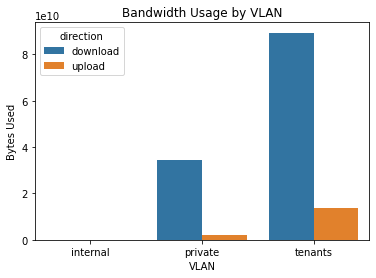

In [17]:
# plot the vlan summary
sns.barplot(
    data=df_summary_vlan.toPandas(),
    x='vlan',
    y='sum(bytes_used)',
    hue='direction'
).set(
    title='Bandwidth Usage by VLAN',
    ylabel='Bytes Used',
    xlabel='VLAN'
)

In [14]:
# remove the internal ip addresses form the dataset
df_minute_vlan = df_minute_vlan_all \
    .where('vlan != "internal"')

print(f'Row Count: {df_minute_vlan.count():,}')

Row Count: 165,544


##### Daily Bandwidth Usage

In [96]:
# get the summary data
df_daily_summary = df_minute_vlan \
    .groupBy('year', 'month', 'day', 'vlan') \
    .sum('bytes_used') \
    .orderBy('year', 'month', 'day', 'vlan').toPandas()

df_daily_summary.head()

,year,month,day,vlan,sum(bytes_used)
0,2022,3,4,private,138364651
1,2022,3,4,tenants,2518310329
2,2022,3,5,private,13337844087
3,2022,3,5,tenants,21974716480
4,2022,3,6,private,9746012979


In [97]:
# add a date column
df_daily_summary['date'] = pd.to_datetime(df_daily_summary[['year', 'month', 'day']])
df_daily_summary.drop(columns=['year', 'month', 'day'], inplace=True)

df_daily_summary.head()

,vlan,sum(bytes_used),date
0,private,138364651,2022-03-04
1,tenants,2518310329,2022-03-04
2,private,13337844087,2022-03-05
3,tenants,21974716480,2022-03-05
4,private,9746012979,2022-03-06


In [98]:
# resample the data to fill gaps if present
df_daily_summary_resampled = df_daily_summary \
    .set_index('date') \
    .groupby('vlan') \
    .resample('D') \
    .sum() \
    .ffill() \
    .reset_index()

# add a gigabytes column
df_daily_summary_resampled['gigabytes'] = df_daily_summary_resampled['sum(bytes_used)'] / 1e9
#df_daily_summary_resampled.sort_values('vlan', inplace=True)

df_daily_summary_resampled.head(10)

,vlan,date,sum(bytes_used),gigabytes
0,private,2022-03-04,138364651,0.138365
1,private,2022-03-05,13337844087,13.337844
2,private,2022-03-06,9746012979,9.746013
3,private,2022-03-07,12818470359,12.818470
4,private,2022-03-08,387526707,0.387527
5,tenants,2022-03-04,2518310329,2.518310
6,tenants,2022-03-05,21974716480,21.974716
7,tenants,2022-03-06,36606105290,36.606105
8,tenants,2022-03-07,40302727457,40.302727
9,tenants,2022-03-08,1564159836,1.564160


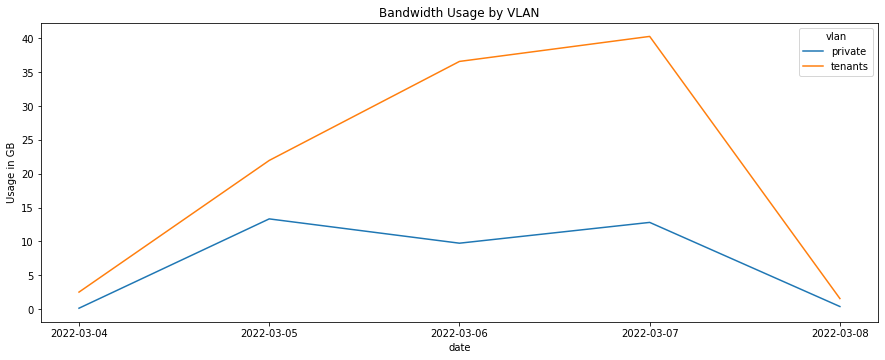

In [106]:
# configure the plot
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

# get x tick labels
x_dates = df_daily_summary_resampled['date'].dt.strftime('%Y-%m-%d').sort_values().unique()

sns.lineplot(
    data=df_daily_summary_resampled,
    x='date',
    y='gigabytes',
    hue='vlan',
    ax=ax
).set(
    title='Bandwidth Usage by VLAN',
    ylabel='Usage in GB',
    xticks=df_daily_summary_resampled.date.unique()
    x
)

plt.show()